In [75]:
import os 
import pandas as pd
import numpy as np
import subprocess
import sys
import shutil
from distutils.dir_util import copy_tree
import distutils
from datetime import datetime, timedelta
import matplotlib.pyplot as plt


%matplotlib notebook

In [76]:
def TS_Describe_stats(data, dateCol, ValCol):
    mindate = data[dateCol].min()
    maxdate = data[dateCol].max()
    daterez = data[dateCol][1]-data[dateCol][0]
    minval = data[ValCol].min()
    maxval = data[ValCol].max()
    aveval = data[ValCol].mean()
    medval = data[ValCol].median()
    print("Date range = {} to {}".format(mindate, maxdate))
    print("Timestep is {}".format(daterez))
    print("Value range is {} to {}".format(minval, maxval))   
    print("Average value is {}".format(aveval))
    print("Median value is {}".format(medval)) 
    print('\n')


# Rain gauge file creation Function Obviously requires very specific input formatting

def gag_me(Input_Precip_File, FileNamePlace, StartDate, EndDate, Lat, Lon, GageName, Resampling_timestep_Mins,
           Precip_column_Name, ImpPrecip_units="Inches"):

    Full_Frame = pd.read_csv(Input_Precip_File, index_col=0, parse_dates=True)   # read in data 
    SliceFrame = Full_Frame[StartDate:EndDate]

    # Format date string for dumb file 
    SliceFrame_format = SliceFrame.copy()
    SliceFrame_format['da'] = SliceFrame_format.index.strftime('%Y %m %d %H %M')
    SliceFrame_format['datedumb'] = SliceFrame_format['da'].str[:]

    # Pull extranious columns 
    SliceFrame_format = SliceFrame_format[['datedumb', Precip_column_Name]]

    # Turn rain in to rain MM 
    if ImpPrecip_units == "Inches": 
        SliceFrame_format[Precip_column_Name+"_mm"] = SliceFrame_format[Precip_column_Name]*25.4 
        Precip_column_Name = Precip_column_Name+"_mm"
        
        
    ### Testing 123
    SliceFrame_format[Precip_column_Name] = SliceFrame_format[Precip_column_Name]*4

    # Round off the number of significant figs
    sigfigs = 3
    SliceFrame_format[Precip_column_Name] = SliceFrame_format[Precip_column_Name].round(sigfigs).apply(lambda x: 
                                                                                                 '{0:g}'.format(float(x)))
 
    # Put the GAGES card on EVery single row 
    SliceFrame_format["trash"] = "GAGES"

    # reorder columns 
    SliceFrame_format = SliceFrame_format[["trash", "datedumb", Precip_column_Name]]

    # Print it off to a txt file with no header, no index and space separator
    SliceFrame_format.to_csv(FileNamePlace, index=False, sep=' ', header = False) 

    # Remove dumb double quotes 
    with open(FileNamePlace,'r') as file:
        data = file.read()
        data = data.replace('"','')
    with open(FileNamePlace,'w') as file:    
        file.write(data)


    # Create the required header lines for WMS gag  files 
    AddLine = 'EVENT "Rain Gage" \nNRGAG 1 \nNRPDS {}\nCOORD {} {} "{}"'.format(len(SliceFrame_format),Lat, Lon, GageName)  

    with open(FileNamePlace, "r+") as f:
         old = f.read() # read everything in the file
         f.seek(0) # rewind
         f.write("{}\n".format(AddLine) + old) # write the new line before

    # Calculate the number of minutes to run the damn thing. 
    Total_Run_Length = Resampling_timestep_Mins*len(SliceFrame_format)
    print("Simulation time is {} minutes".format(Total_Run_Length))
    print("number of time rows is {}".format(len(SliceFrame_format)))

    
    return Total_Run_Length, SliceFrame_format


# Process streamflow datasets from da files 
def Isolate_Stream_Data(Input_Stream_File, StreamFlow_column_Name, StartDate, EndDate):
    Full_Frame = pd.read_csv(Input_Stream_File, index_col=0, parse_dates=True)
    SliceFrame = Full_Frame[StartDate:EndDate]

    return SliceFrame[[StreamFlow_column_Name]]



# Process outlet file from GSSHA into a pandas dataframe 
def process_otl_file(StartDate, OutletFile):

    # Create the start time object to enumerate the number of minutes in the outlet file 
    StartDateTime = datetime.strptime(StartDate, '%Y-%m-%d %H:%M')
    
    # read in the outlet file 
    OutHydro = pd.read_csv(OutletFile, names=["Minutes", "CFS"], delim_whitespace=True)
    
    # da magic: Turn stupid minutes into useful datetime objects 
    OutHydro["date"] = OutHydro["Minutes"].apply(lambda x: StartDateTime + timedelta(minutes=x))
    
    # Set the index to the date
    OutHydro.set_index("date", inplace=True)
    
    return OutHydro



def cmt_prama_jama(MapTableFile, Param, Val):
    with open(MapTableFile, 'r') as file :    # Read in the file 
        filedata = file.read()

    filedata = filedata.replace(Param, Val)  # Replace the target paramater(s)

    with open(MapTableFile, 'w') as file:   # Write the file out again
        file.write(filedata)
        
        
def nse(predictions, targets):
    return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))

### Project variables to set 

In [77]:
# Umbrella variables 

PrjName = "test4"               # Project File name from the WMS save 

Resampling_timestep_Mins = 60


#########   Precip file and Rain Gauge  #############

Precip_column_Name       =  "FIELD_28Rain"

Input_Precip_File   =  os.path.join("..", "input_data", "Merged_Rainfall_mm.csv")  # note Date time Column needs to be called "datetime" 
ImpPrecip_units     =  "mm"    # "Inches" or "mm"

# Rain Gauge Location info   (Currently is random spot)
Lat  = 753354.0       # For Waihehe 753354,    # For WaiehuKou,"758000.0"     
Lon  = 2314472.0       # For Waihehe 2314472,     # For WaiehuKou,"2315555.0" 
GageName    = "Gage2_Waihehe"

# Output Rain GAG file location 
FileNamePlace = os.path.join(".","RUN", "{}.gag".format(PrjName))


#########   Stream files #############         
# Stream Data Variables for Waihehe
Input_Stream_File        =  os.path.join("..", "input_data", "OBS_data_rain_Streams_2007-2021.csv")  # note Date time Column needs to be called "datetime" 

# Stream Data Variables for Wailuku
Input_Stream_File        =  os.path.join("..", "input_data", "OBS_data_rain_Streams_2007-2021.csv")  # note Date time Column needs to be called "datetime" 


In [78]:
# Import the high flow days from the following files
Big_WaiheheFlow_Days_DF = pd.read_csv(os.path.join("..", "input_data", "biguns_WaiheheFlow_1d.csv"))
Big_WaiheheFlow_Days_DF['datetime'] = pd.to_datetime(Big_WaiheheFlow_Days_DF['datetime'], errors='coerce')

Simulation time is 5820 minutes
number of time rows is 97
The NSE is -409.39460054056053
for event 2013-08-10 00:00:00,  NSE is -409.39460054056053


<IPython.core.display.Javascript object>


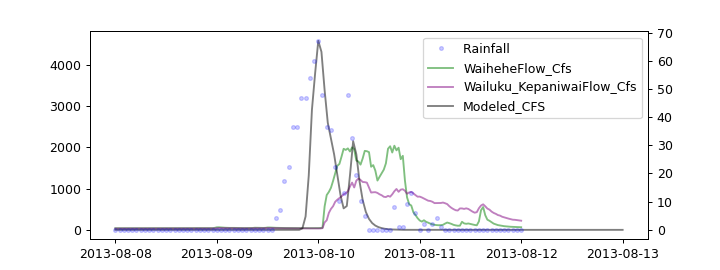

Simulation time is 5820 minutes
number of time rows is 97
The NSE is -176.38513331402845
for event 2014-12-23 00:00:00,  NSE is -176.38513331402845


<IPython.core.display.Javascript object>


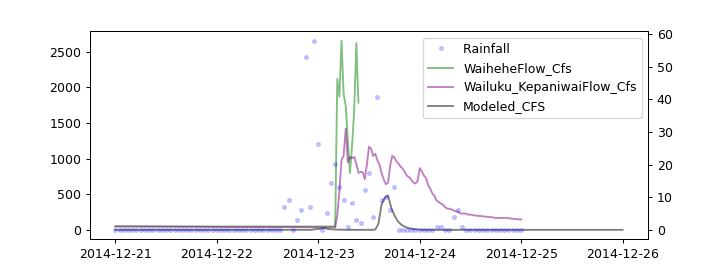

Simulation time is 5820 minutes
number of time rows is 97
The NSE is -239.4016232055082
for event 2016-09-13 00:00:00,  NSE is -239.4016232055082


<IPython.core.display.Javascript object>


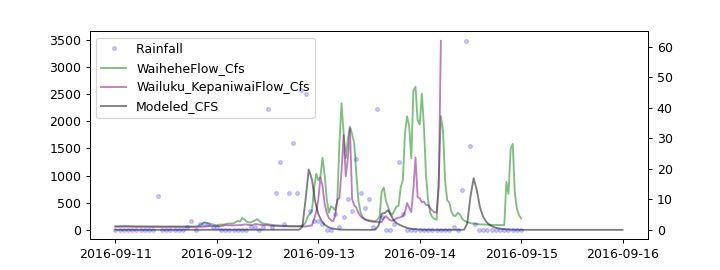

Simulation time is 0 minutes
number of time rows is 0
The NSE is nan
for event 1994-03-23 00:00:00,  NSE is nan


C:\Users\CS\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\CS\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\CS\AppData\Local\Temp\ipykernel_10224\3011727873.py:120: RuntimeWarning: invalid value encountered in double_scalars
  return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))


<IPython.core.display.Javascript object>


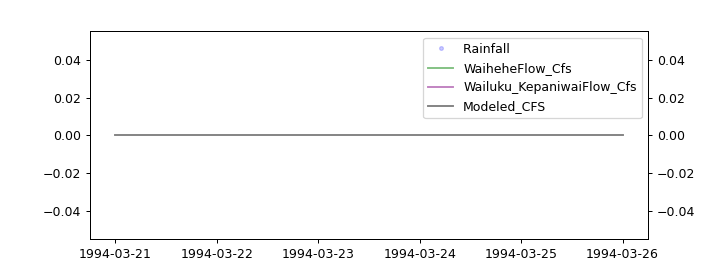

Simulation time is 5820 minutes
number of time rows is 97
The NSE is -204.01234831774323
for event 2012-03-25 00:00:00,  NSE is -204.01234831774323


<IPython.core.display.Javascript object>


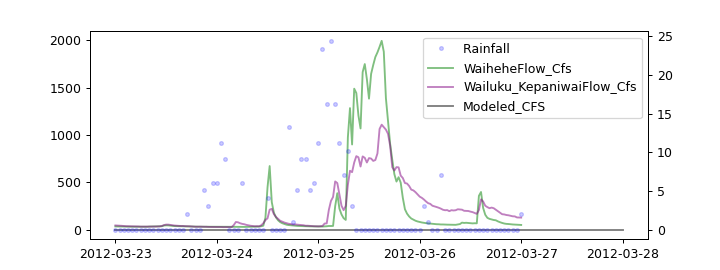

Simulation time is 5820 minutes
number of time rows is 97
The NSE is -201.56989569648178
for event 2013-11-11 00:00:00,  NSE is -201.56989569648178


<IPython.core.display.Javascript object>


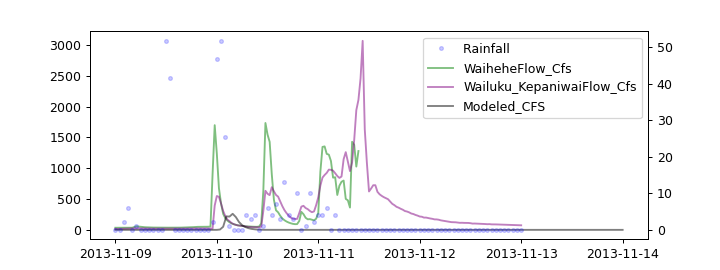

Simulation time is 5820 minutes
number of time rows is 97
The NSE is -188.36687197798827
for event 2017-10-13 00:00:00,  NSE is -188.36687197798827


<IPython.core.display.Javascript object>


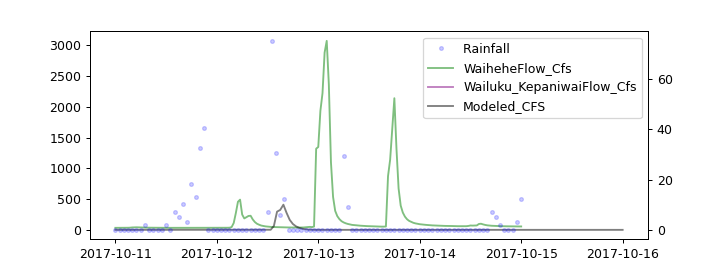

Simulation time is 5820 minutes
number of time rows is 97
The NSE is -245.65651844705772
for event 2015-04-28 00:00:00,  NSE is -245.65651844705772


<IPython.core.display.Javascript object>


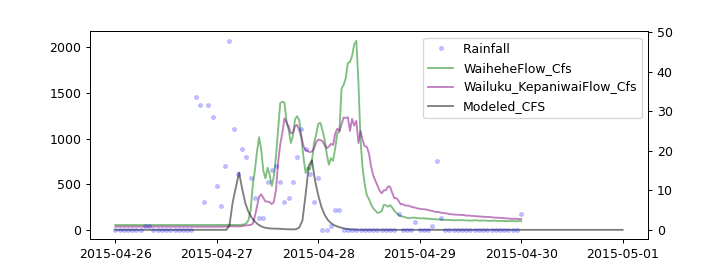

Simulation time is 5820 minutes
number of time rows is 97
The NSE is -231.91143595283174
for event 2017-12-21 00:00:00,  NSE is -231.91143595283174


<IPython.core.display.Javascript object>


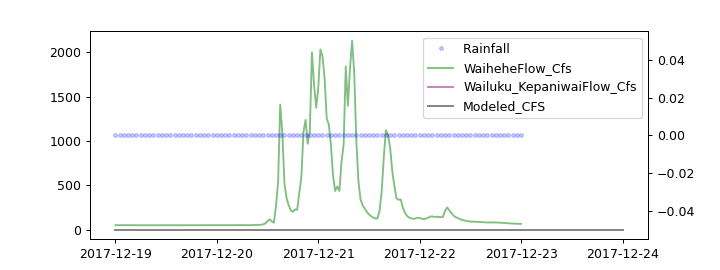

In [81]:
# Run the model iterativly


date_list = []
NSE_list  = []

for i in Big_WaiheheFlow_Days_DF['datetime']:
    
    StartDate = (i-timedelta(days=2)).strftime('%Y-%m-%d %H:%M')
    EndDate = (i+timedelta(days=2)).strftime('%Y-%m-%d %H:%M')
    
    # Run function to create stream and precip OBS dataframe 
    WaiheheCFS = Isolate_Stream_Data(Input_Stream_File, "WaiheheFlow", StartDate, EndDate)
    WailukuCFS = Isolate_Stream_Data(Input_Stream_File, "Wailuku_KepaniwaiFlow", StartDate, EndDate)
    
    # Run the Rain Gauge Creation Function 
    Total_Run_Length, Rain_Data_Frame = gag_me(
        Input_Precip_File, FileNamePlace, StartDate, EndDate, Lat, Lon, 
        GageName, Resampling_timestep_Mins,
               Precip_column_Name, ImpPrecip_units=ImpPrecip_units)
    
    
    
    ##########    RUN THE MODEL   #################
    # Run the GSSHA process in the command line 
    os.chdir(os.path.join(".", "RUN"))         # Chanfge into run directoy 
    subprocess.call('gssha.exe {}.prj'.format(PrjName), shell=True)
    os.chdir(os.path.join(".."))                # Change back out of run directory 

    # Process the Run's Output hydrograph into a dataframe 
    OutletFile = os.path.join("RUN", PrjName)+".otl"
    OutHydro = process_otl_file(StartDate, OutletFile)


    # NSE calculation          
    predictions = OutHydro['CFS'].to_numpy()
    targets = WaiheheCFS.resample('60T').mean().to_numpy()
    NSE_stat = nse(predictions, np.nan_to_num(targets))
    print("The NSE is {}".format(NSE_stat))
    
    date_list.append(i)
    NSE_list.append(NSE_stat)
    
    print("for event {},  NSE is {}".format(i, NSE_stat))
    
    
  # Plot it quick 
    fig, ax = plt.subplots(figsize=(8, 3))
    ax2 = ax.twinx()
    # For some reason need to cast the rainfall as a number not object?
    Rain_Data_Frame[Precip_column_Name] = Rain_Data_Frame[Precip_column_Name].apply(lambda x: float(x))
    lns0 = ax2.plot(Rain_Data_Frame[Precip_column_Name], '.', c='b', alpha=0.2, label="Rainfall ")
    
    
    lns1 = ax.plot(WaiheheCFS["WaiheheFlow"], '-', c='g', alpha=0.5, label="WaiheheFlow_Cfs")
    lns2 = ax.plot(WailukuCFS["Wailuku_KepaniwaiFlow"], '-', c='purple', alpha=0.5, label="Wailuku_KepaniwaiFlow_Cfs")
    lns3 = ax.plot(OutHydro['CFS'], '-', c='k', alpha=0.5, label="Modeled_CFS")
    lns = lns0+lns1+lns2+lns3
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0)

# Older iteration of the model run 

Simulation time is 5820 minutes
number of time rows is 97


<IPython.core.display.Javascript object>


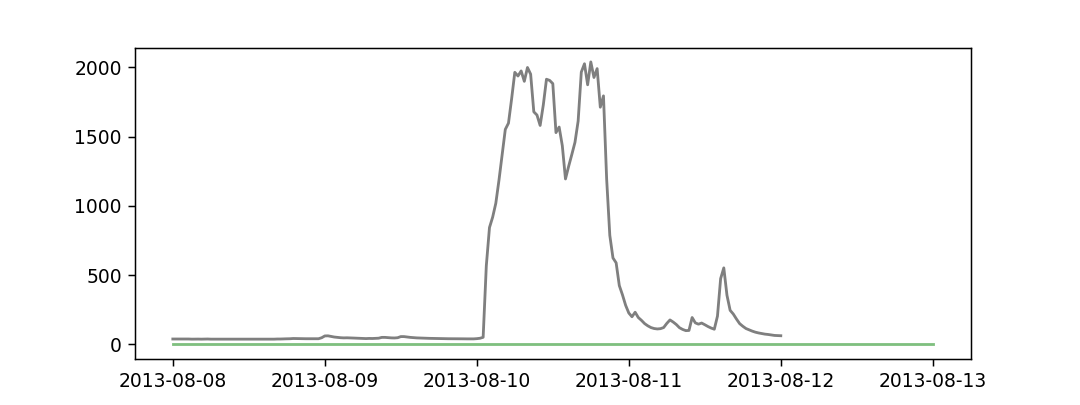

The NSE is -224.47088933690662
for event 2013-08-10 00:00:00,  NSE is -224.47088933690662
Simulation time is 5820 minutes
number of time rows is 97


<IPython.core.display.Javascript object>


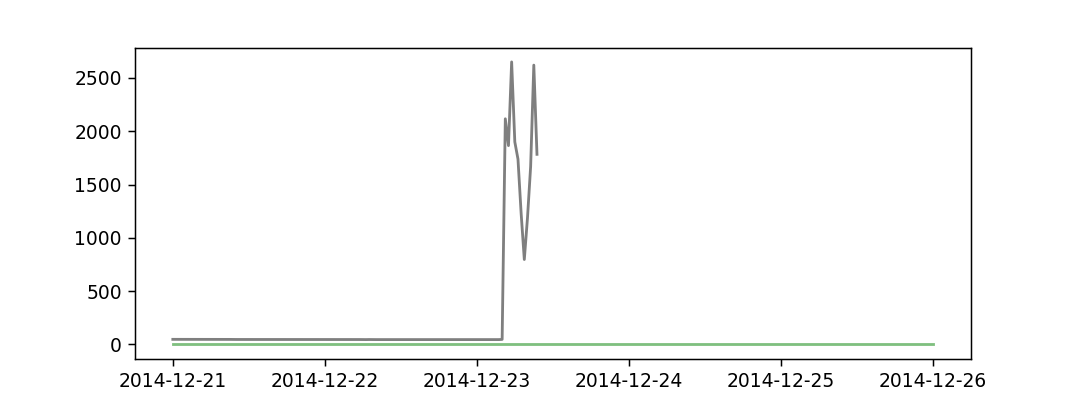

The NSE is -175.44659742289207
for event 2014-12-23 00:00:00,  NSE is -175.44659742289207
Simulation time is 5820 minutes
number of time rows is 97


<IPython.core.display.Javascript object>


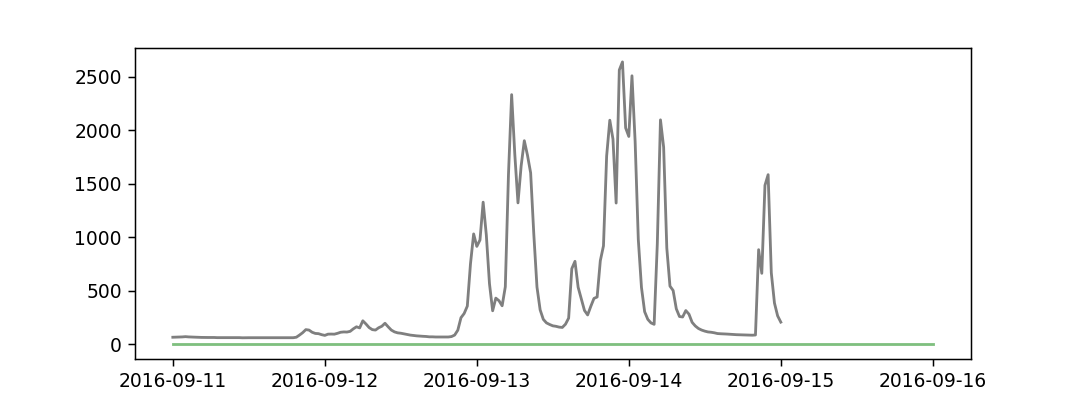

The NSE is -246.5255278770816
for event 2016-09-13 00:00:00,  NSE is -246.5255278770816
Simulation time is 0 minutes
number of time rows is 0


<IPython.core.display.Javascript object>


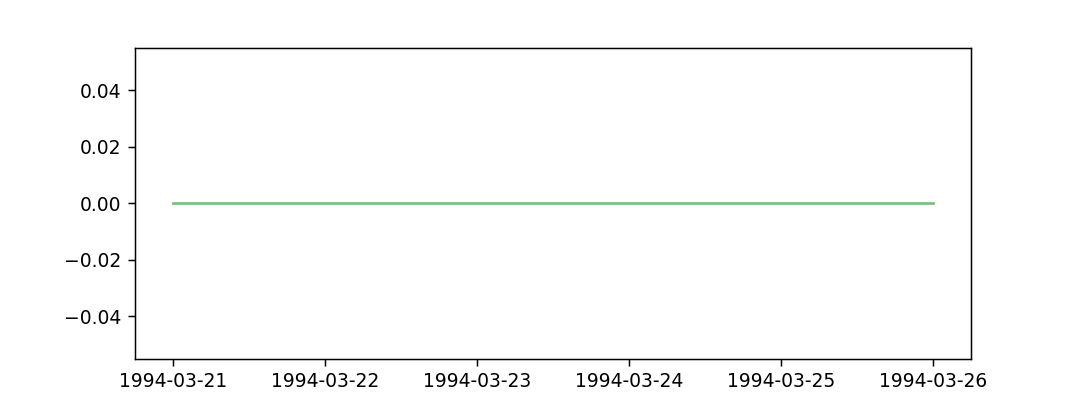

C:\Users\CS\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\CS\anaconda3\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\CS\AppData\Local\Temp\ipykernel_12204\2476246155.py:117: RuntimeWarning: invalid value encountered in double_scalars
  return (1-(np.sum((predictions-targets)**2)/np.sum((targets-np.mean(targets))**2)))


The NSE is nan
for event 1994-03-23 00:00:00,  NSE is nan
Simulation time is 5820 minutes
number of time rows is 97


<IPython.core.display.Javascript object>


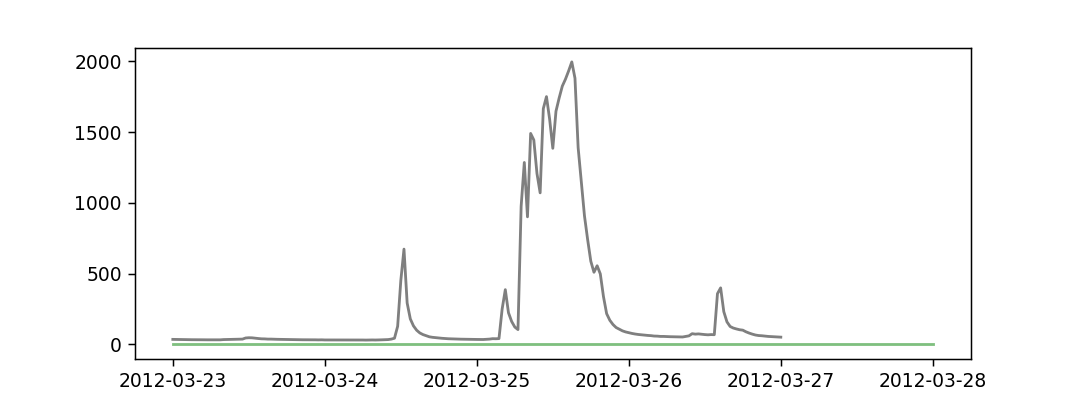

The NSE is -204.01234831774323
for event 2012-03-25 00:00:00,  NSE is -204.01234831774323
Simulation time is 5820 minutes
number of time rows is 97


<IPython.core.display.Javascript object>


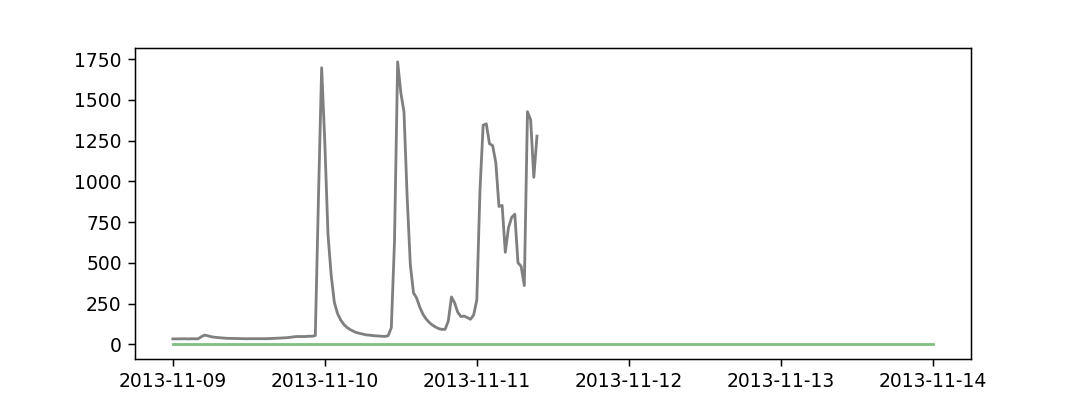

The NSE is -203.40733612060043
for event 2013-11-11 00:00:00,  NSE is -203.40733612060043
Simulation time is 5820 minutes
number of time rows is 97


<IPython.core.display.Javascript object>


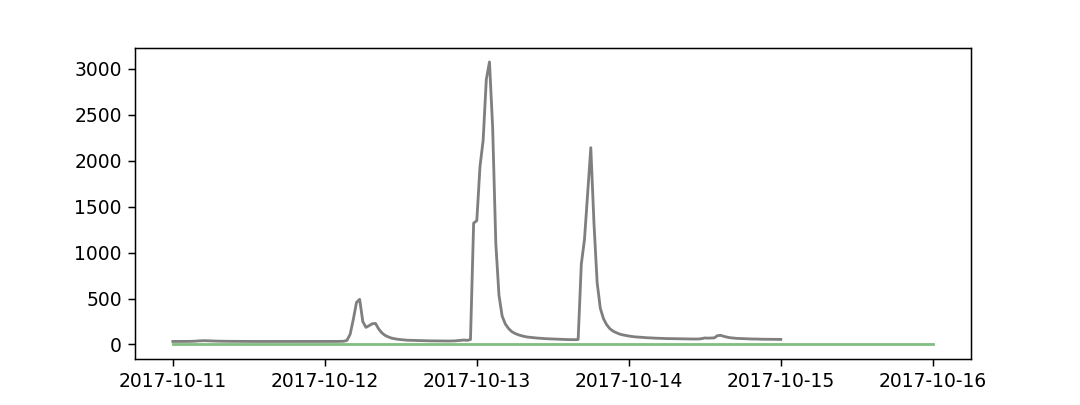

The NSE is -189.33417975658978
for event 2017-10-13 00:00:00,  NSE is -189.33417975658978
Simulation time is 5820 minutes
number of time rows is 97


<IPython.core.display.Javascript object>


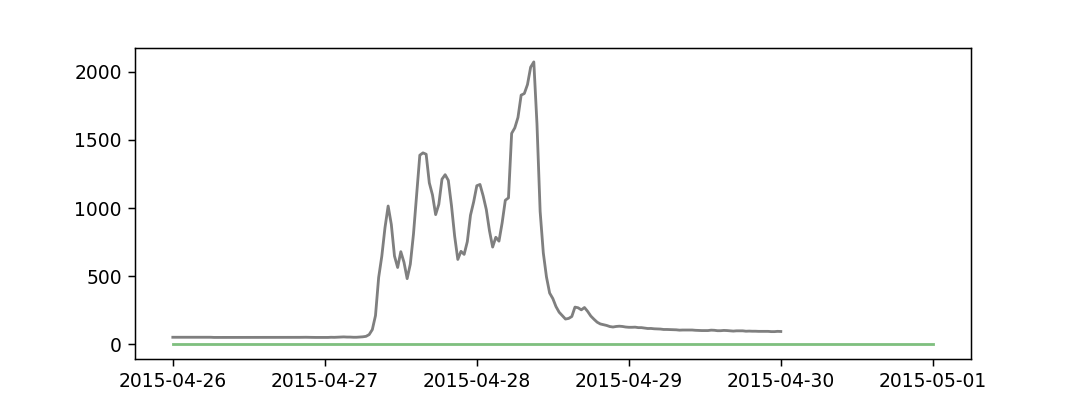

The NSE is -253.92878159312863
for event 2015-04-28 00:00:00,  NSE is -253.92878159312863
Simulation time is 5820 minutes
number of time rows is 97


<IPython.core.display.Javascript object>


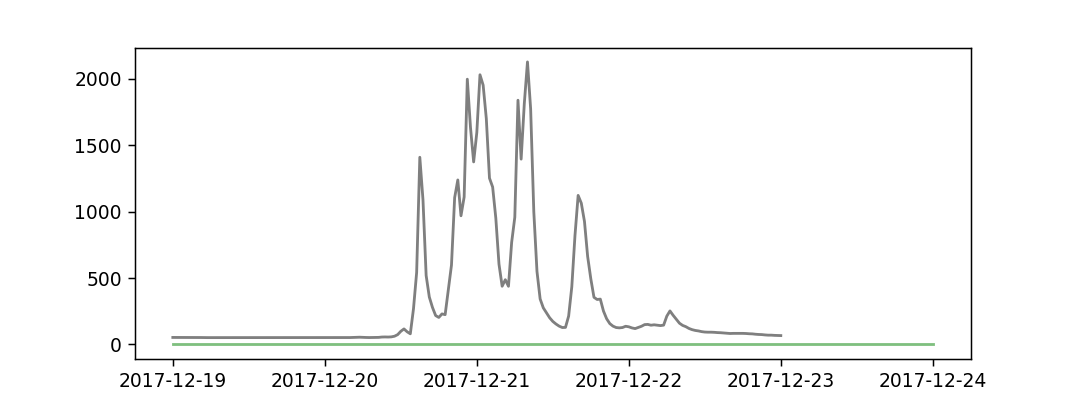

The NSE is -231.91143595283174
for event 2017-12-21 00:00:00,  NSE is -231.91143595283174


In [53]:
date_list = []
NSE_list  = []

for i in Big_WaiheheFlow_Days_DF['datetime']:
    
    StartDate = (i-timedelta(days=2)).strftime('%Y-%m-%d %H:%M')
    EndDate = (i+timedelta(days=2)).strftime('%Y-%m-%d %H:%M')
    
    # Priject File name from the WMS save 
    PrjName = "test4"         

    # Precip variables
    Input_Precip_File   =  os.path.join("..", "input_data", "Merged_Rainfall_mm.csv")  # note Date time Column needs to be called "datetime" 
    Precip_column_Name       =  "OGG_Rain"
    ImpPrecip_units     =  "mm"    # "Inches" or "mm"

    # Event Variables 
    #StartDate   =  "2018-08-23 00:00"
    # EndDate     =    "2018-08-27 00:00"
    Resampling_timestep_Mins = 60

    # Rain Gauge Location info 
    Lat  = 753354.0       # For Waihehe 753354,    # For WaiehuKou,"758000.0"
    Lon  = 2314472.0       # For Waihehe 2314472,     # For WaiehuKou,"2315555.0" 
    GageName    = "Gage2_Waihehe"


    # Output Rain GAG file location 
    FileNamePlace = os.path.join(".","RUN", "{}.gag".format(PrjName))

    # Run the Rain Gauge Creation Function 
    Total_Run_Length, Rain_Data_Frame = gag_me(
        Input_Precip_File, FileNamePlace, StartDate, EndDate, Lat, Lon, 
        GageName, Resampling_timestep_Mins,
               Precip_column_Name, ImpPrecip_units=ImpPrecip_units)
    
    
    
    
    # Stream Data Variables for Waihehe
    Input_Stream_File        =  os.path.join("..", "input_data", "OBS_data_rain_Streams_2007-2021.csv")  # note Date time Column needs to be called "datetime" 
    # Run function to create stream OBS dataframe 
    WaiheheCFS = Isolate_Stream_Data(Input_Stream_File, "WaiheheFlow", StartDate, EndDate)

    # Stream Data Variables for Wailuku
    Input_Stream_File        =  os.path.join("..", "input_data", "OBS_data_rain_Streams_2007-2021.csv")  # note Date time Column needs to be called "datetime" 
    # Run function to create stream OBS dataframe 
    WailukuCFS = Isolate_Stream_Data(Input_Stream_File, "Wailuku_KepaniwaiFlow", StartDate, EndDate)


    ##########    RUN THE MODEL   #################
    # Run the GSSHA process in the command line 
    os.chdir(os.path.join(".", "RUN"))         # Chanfge into run directoy 
    subprocess.call('gssha.exe {}.prj'.format(PrjName), shell=True)
    os.chdir(os.path.join(".."))                # Change back out of run directory 

    # Process the Run's Output hydrograph into a dataframe 
    OutletFile = os.path.join("RUN", PrjName)+".otl"
    OutHydro = process_otl_file(StartDate, OutletFile)

    # Plot it quick 
    fig, ax = plt.subplots(figsize=(8, 3))
    ax.plot(OutHydro['CFS'], '-', c='g', alpha=0.5, label="Modeled_CFS")
    ax.plot(WaiheheCFS["WaiheheFlow"], '-', c='k', alpha=0.5, label="WaiheheFlow_Cfs")


    # NSE calculation          
    predictions = OutHydro['CFS'].to_numpy()
    targets = WaiheheCFS.resample('60T').mean().to_numpy()
    NSE_stat = nse(predictions, np.nan_to_num(targets))
    print("The NSE is {}".format(NSE_stat))
    
    
    date_list.append(i)
    NSE_list.append(NSE_stat)
    
    print("for event {},  NSE is {}".format(i, NSE_stat))
    
    
    
    
    
    
    
    

In [50]:
With the Original USGS Puukukui Rainfall data 
pd.DataFrame({"datetime":date_list, "NSE":NSE_list})

,datetime,NSE
0,2013-08-10,-224.470889
1,2014-12-23,-175.446597
2,2016-09-13,-297.219848
3,1994-03-23,NaN
4,2012-03-25,-203.999420
5,2013-11-11,-293.789522
6,2017-10-13,-189.334180
7,2015-04-28,-253.928660
8,2017-12-21,-231.911350


In [82]:
Big_WaiheheFlow_Days_DF

,Unnamed: 0,datetime,Flow_CFS
0,0,2013-08-10,1483.608065
1,1,2014-12-23,1390.440741
2,2,2016-09-13,1160.376289
3,3,1994-03-23,1039.062500
4,4,2012-03-25,1033.214286
5,5,2013-11-11,979.523810
6,6,2017-10-13,971.287162
7,7,2015-04-28,962.419890
8,8,2017-12-21,953.740741


In [ ]:
BigDay_List = ['2013-08-10 00:00:00',
 '2014-12-23 00:00:00',
 '2016-09-13 00:00:00',
 '1994-03-23 00:00:00',
 '2012-03-25 00:00:00',
 '2013-11-11 00:00:00',
 '2017-10-13 00:00:00',
 '2015-04-28 00:00:00',
 '2017-12-21 00:00:00']